In [ ]:
import kagglehub
koryakinp_fingers_path = kagglehub.dataset_download('koryakinp/fingers')

print('Data source import complete.')


100%|██████████| 363M/363M [00:05<00:00, 64.7MB/s]

Extracting files...


Data source import complete.


In [5]:
!pip install tensorflow==2.14.0
!pip install numpy==1.26.4
!pip install scikit-learn==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [3]:
# Load the paths of the images
trainpaths = os.listdir("/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/train")
testpaths = os.listdir("/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/test")

# Add the all path to the paths of the images
train_str = "/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/train/"
trainpaths = ["/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/train/" + p for p in trainpaths]

test_str = "/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/test/"
testpaths = ["/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/test/" + p for p in testpaths]

# Create a DataFrame with the paths
df_train = pd.DataFrame(trainpaths, columns=['Filepath'])
df_train['set'] = 'train'

df_test = pd.DataFrame(testpaths, columns=['Filepath'])
df_test['set'] = 'test'

image_df = pd.concat([df_train,df_test])
image_df.reset_index(drop = True, inplace = True)

# Display the first rows
image_df.head(5)

,Filepath,set
0,/root/.cache/kagglehub/datasets/koryakinp/fing...,train
1,/root/.cache/kagglehub/datasets/koryakinp/fing...,train
2,/root/.cache/kagglehub/datasets/koryakinp/fing...,train
3,/root/.cache/kagglehub/datasets/koryakinp/fing...,train
4,/root/.cache/kagglehub/datasets/koryakinp/fing...,train


In [4]:
# The number of fingers is the second character on the left of .png
# In this example, it is 4 (fingers)
image_df.iloc[0][0]

<ipython-input-4-83eb238e7538>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_df.iloc[0][0]


'/root/.cache/kagglehub/datasets/koryakinp/fingers/versions/2/fingers/train/ba435a31-b12c-4a43-a964-acb4795828fc_4R.png'

In [5]:
# Create the labels (number of fingers)
image_df['Label'] = image_df['Filepath'].apply(lambda x: x[-6])

# Create the labels for a right or a left hand
image_df['Label_LR'] = image_df['Filepath'].apply(lambda x: x[-5])

# Shuffle the DataFrame
image_df = image_df.sample(frac=1,random_state=0)

# Show the result
image_df.head(5)

,Filepath,set,Label,Label_LR
641,/root/.cache/kagglehub/datasets/koryakinp/fing...,train,1,R
14864,/root/.cache/kagglehub/datasets/koryakinp/fing...,train,1,L
19127,/root/.cache/kagglehub/datasets/koryakinp/fing...,test,2,R
4202,/root/.cache/kagglehub/datasets/koryakinp/fing...,train,5,L
8524,/root/.cache/kagglehub/datasets/koryakinp/fing...,train,0,L


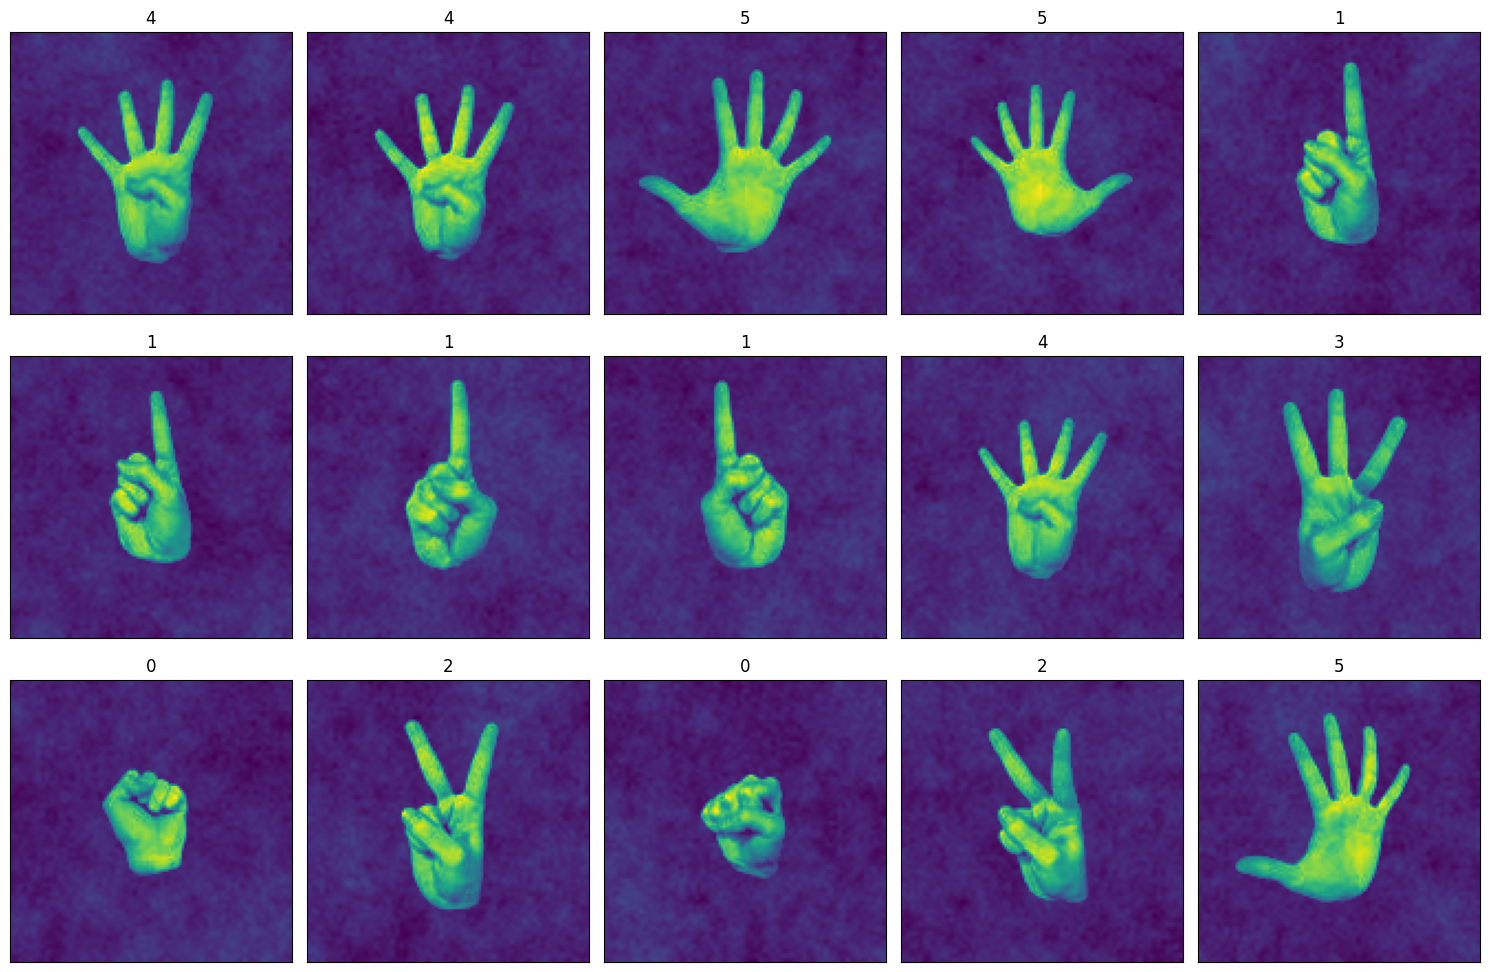

In [6]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# Separe the image_df in the training DataFrame and into the testing DataFrame
train_df = image_df[image_df['set'] == 'train']
test_df = image_df[image_df['set'] == 'test']

# 2. Teach a Neural Network how to count fingers  <a class="anchor" id="2"></a>
## 2.1. Load the Images with a generator<a class="anchor" id="3"></a>

In [8]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## 2.2. Train the model<a class="anchor" id="4"></a>

In [10]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images = create_gen()

Found 16200 validated image filenames belonging to 6 classes.
Found 1800 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/3
507/507 [==============================] - 613s 1s/step - loss: 0.0326 - accuracy: 0.9919 - val_loss: 0.0017 - val_accuracy: 0.9994
Epoch 2/3
507/507 [==============================] - 623s 1s/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 2.4455e-04 - val_accuracy: 1.0000
Epoch 3/3
507/507 [==============================] - 595s 1s/step - loss: 9.5260e-05 - accuracy: 1.0000 - val_loss: 9.7260e-05 - val_accuracy: 1.0000


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Save as an HDF5 file
model.save("/content/drive/My Drive/saved_models_from_colab/finger_counting_model/finger_counting_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


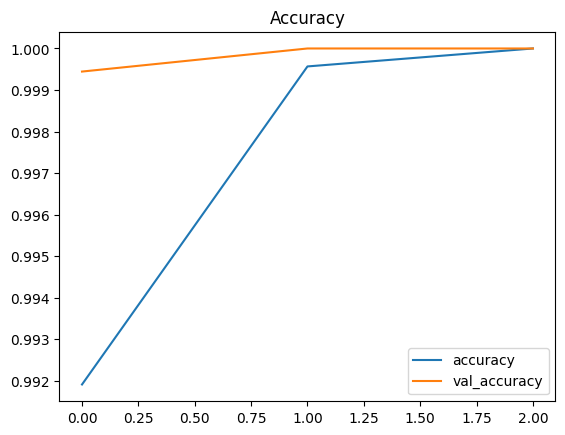

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

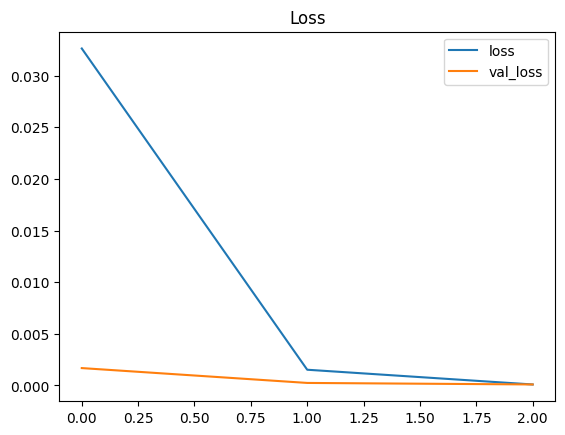

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 2.3. Visualize the result<a class="anchor" id="5"></a>

In [16]:
results = model.evaluate(test_images, verbose=0)

In [17]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.00018

## Accuracy on the test set: 100.00%

In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

113/113 [==============================] - 118s 1s/step
The first 5 predictions: ['2', '2', '0', '0', '3']


In [19]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



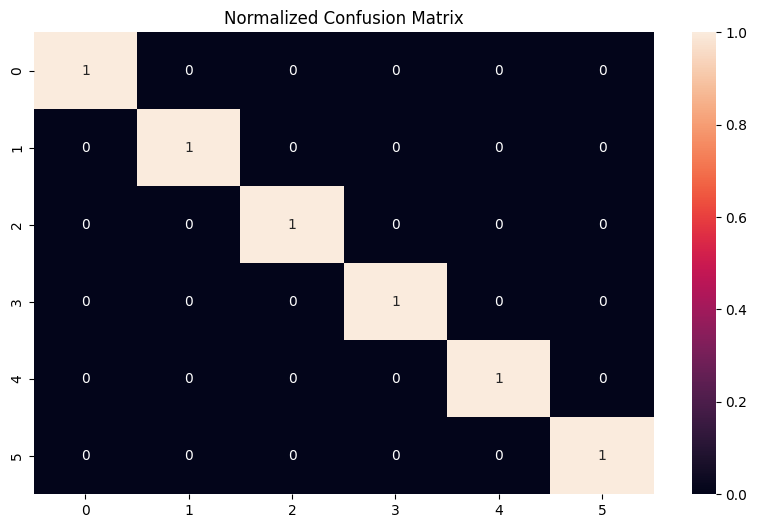

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

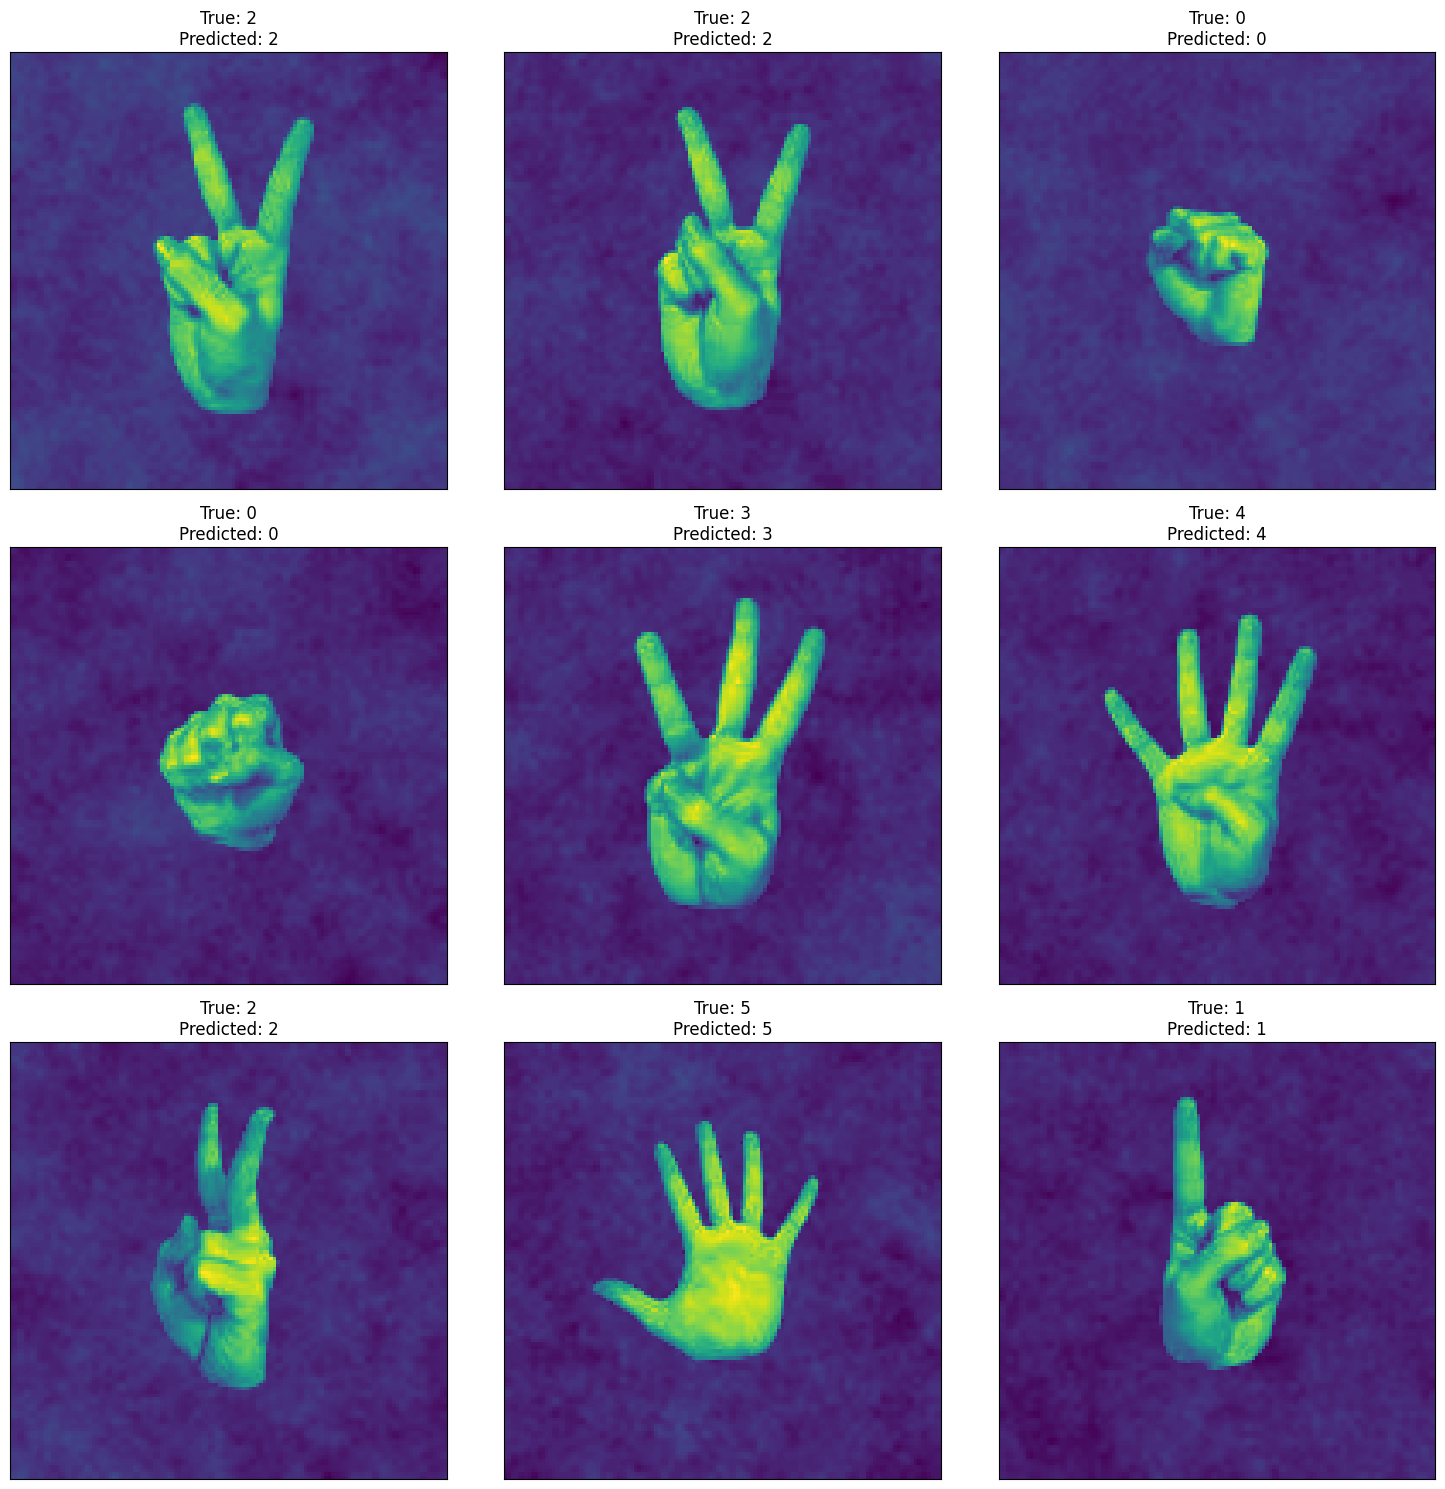

In [21]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 2.4. Class activation heatmap for image classification<a class="anchor" id="6"></a>
### Grad-CAM class activation visualization
*Code adapted from keras.io*

In [22]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-22-c4428af7cdd9>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


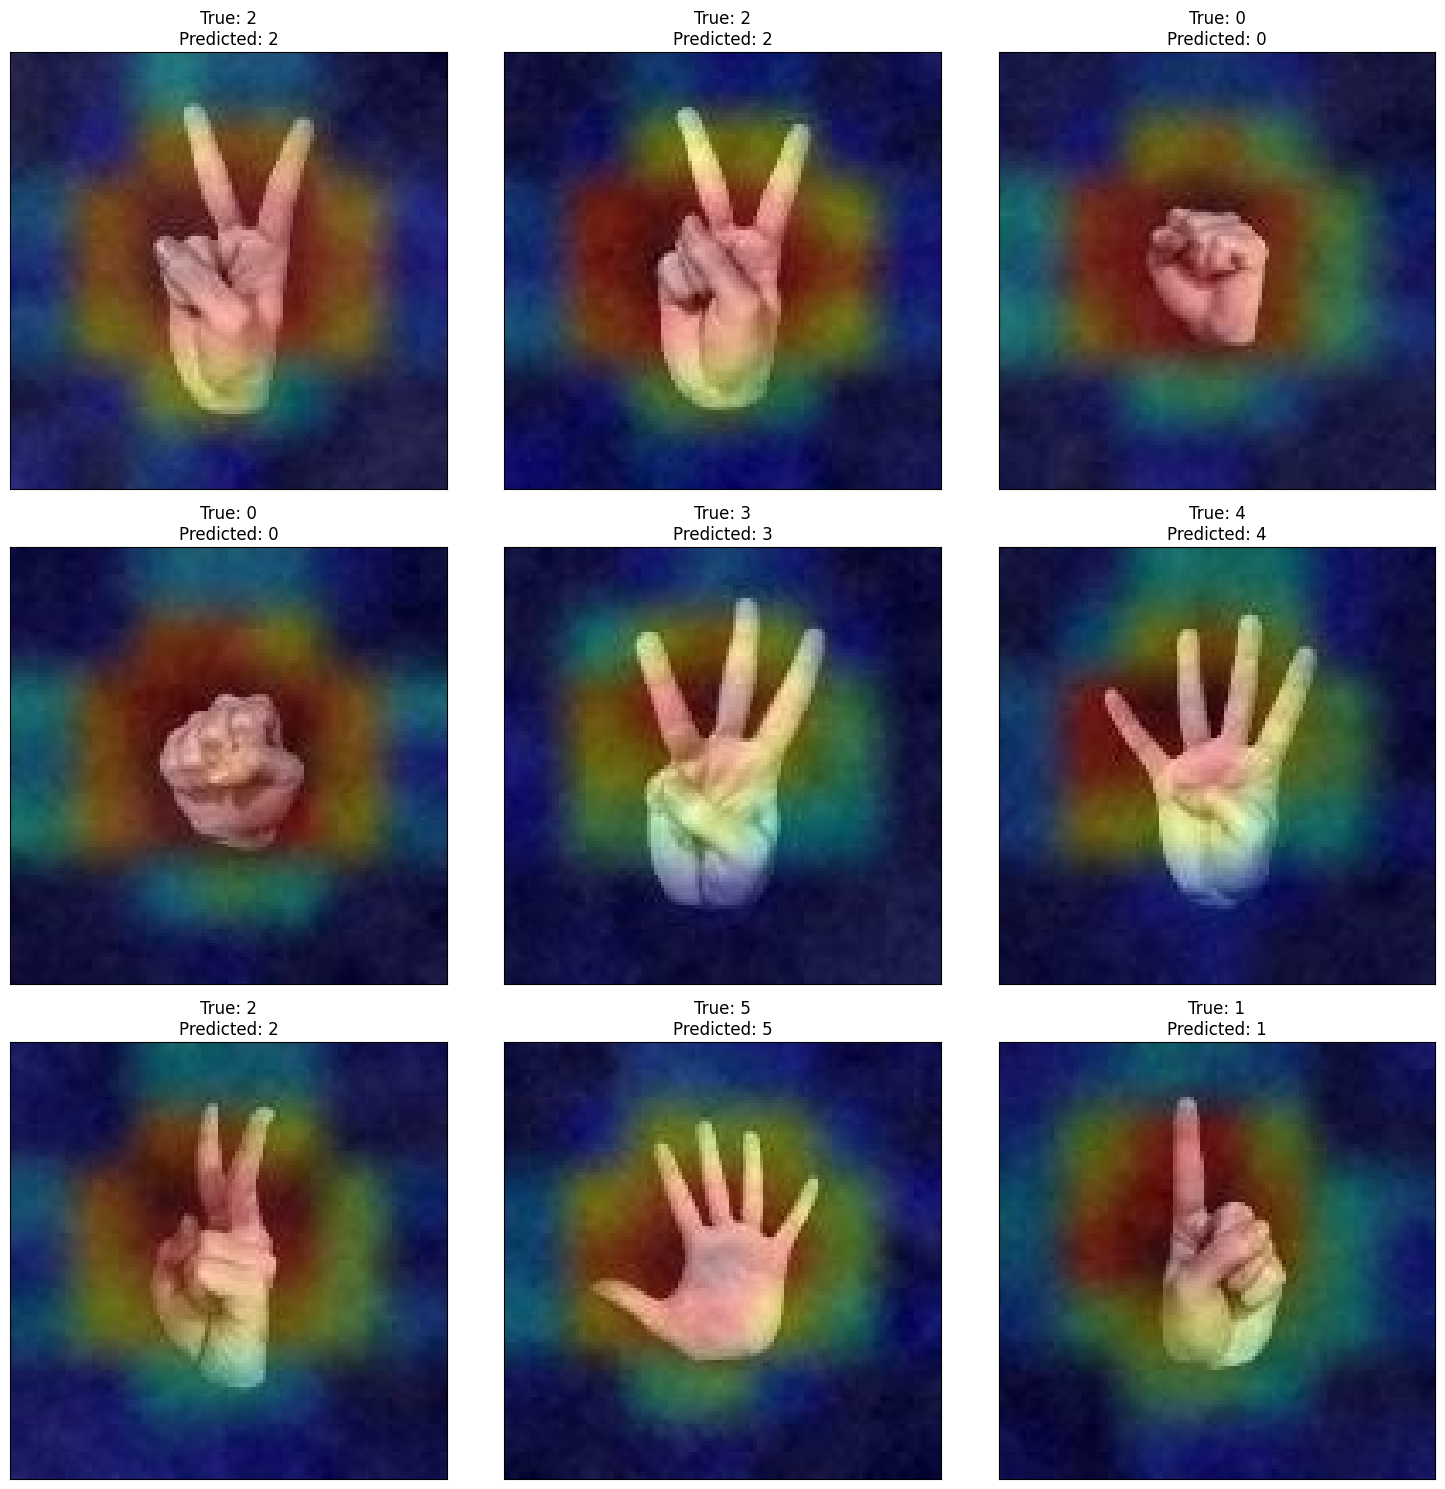

In [23]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()